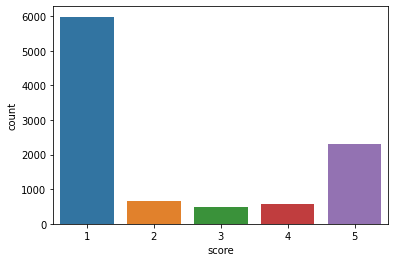

In [3]:
!pip install google-play-scraper
from google_play_scraper import app,Sort,reviews_all
import pandas as pd
import numpy as np
from google_play_scraper import Sort, reviews
result, continuation_token = reviews(
    'cris.org.in.prs.ima', 
    lang='en', 
    country='us',
    count=10000,
    sort=Sort.NEWEST, 
)
#Assembling reviews into a pandas dataframe for better pipelining
df_review=pd.DataFrame(np.array(result),columns=['review'])
df_review=df_review.join(pd.DataFrame(df_review.pop('review').tolist()))
features=df_review['content']
targets=df_review['score']
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=df_review,x=df_review['score'])
plt.show()

In [4]:
new_targets=[]
num_pos=0
num_neg=0
for rows in range(targets.shape[0]):
    temp_score=targets[rows]
    if temp_score>=3:
        new_targets.append(1)
        num_pos+=1
    else:
        new_targets.append(0)
        num_neg+=1

In [5]:
print('Number of positive reviews {}\nNumber of negative reviews {}'.format(num_pos,num_neg))

Number of positive reviews 3368
Number of negative reviews 6632


In [6]:
import nltk 
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PROMIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
corpus=[]
for i in range(0,len(features)):
    pat = r'[^a-zA-z0-9]'
    text=features[i]
    review=re.sub(pat,' ',text)
    review=review.lower()
    review=review.split()
    review=[ps.stem(word) for word in review if word not in stopwords.words('english')]
    review=' '.join(review)
    corpus.append(review)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
tv=TfidfVectorizer(max_features=1000)
X_train,X_test,Y_train,Y_test=train_test_split(features,new_targets,test_size=0.2)

# Random Forest Model

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
X_train=tv.fit_transform(X_train)
X_test=tv.transform(X_test)
rf.fit(X_train,Y_train)

RandomForestClassifier()

In [19]:
rf.score(X_test,Y_test)

0.89

In [20]:
model_accs=[]
for idx,tree in enumerate(rf.estimators_):
    score=tree.score(X_test,Y_test)
    model_accs.append([idx,score])
model_accs=np.array(model_accs)

In [21]:
sorted_indices=np.argsort(model_accs[:,1])[::-1]

In [23]:
model_ids=model_accs[sorted_indices][:,0].astype(int)

In [25]:
rf.estimators_=np.array(rf.estimators_)[model_ids].tolist()

In [26]:
import copy 
result=[]

total_models=len(rf.estimators_)
for k in range(2,total_models):
    small_model=copy.deepcopy(rf)
    small_model.estimators_=rf.estimators_[:k]
    score=small_model.score(X_test,Y_test)
    result.append([i,score])


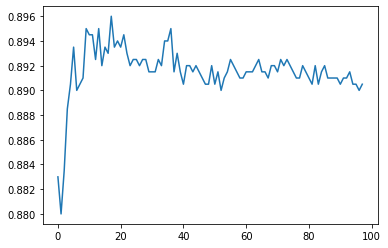

In [31]:
plt.plot(np.array(result)[:,1])

In [33]:
small_model=copy.deepcopy(rf)
small_model.estimators_=rf.estimators_[:k]
small_model.score(X_test,Y_test)

0.8905

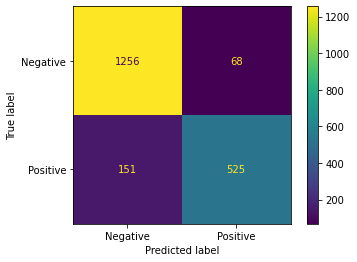

In [37]:
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
preds=small_model.predict(X_test)
cm=confusion_matrix(Y_test,preds)
disp=ConfusionMatrixDisplay(cm,display_labels=['Negative','Positive'])
disp.plot()
plt.show()